# Variance comparison

In this notebook we compare the variances from a naive calculation, bootstrap and blocking.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from vmc.interface import *
from vmc import run_all

from IPython.core.pylabtools import figsize
from IPython.core.display import display

In [2]:
sns.set(color_codes=True)

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

step_length = 0.1
time_step = 0.01

alpha_min = 0.3
alpha_max = 0.7
num_alphas = 11

parameter_names = ["alpha"]

alphas = np.linspace(
    alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

num_particles = 10
num_dimensions = 3

bootstrap_samples = 0

num_samples_list = [int(2**i) for i in range(10, 22)]
num_thermalization_steps = 0

In [4]:
df_dict = {}

In [5]:
for num_samples in num_samples_list:
    kwargs = {
        "num_samples": num_samples, "step_length": step_length,
        "num_thermalization_steps": num_thermalization_steps,
        "sample_local_energies": True}

    sampler_brute = PySampler(
        PySimpleGaussian(
            num_particles, num_dimensions, mass, omega, spread=step_length),
        PyHarmonicOscillator(), PyMetropolisAlgorithm())

    df_brute = run_all(sampler_brute, alphas, parameter_names, bootstrap_samples, **kwargs)

    sampler_imp = PySampler(
        PySimpleGaussian(
            num_particles, num_dimensions, mass, omega, spread=np.sqrt(time_step)),
        PyHarmonicOscillator(), PyImportanceMetropolis())

    kwargs["step_length"] = time_step
    
    df_imp = run_all(sampler_imp, alphas, parameter_names, bootstrap_samples, **kwargs)

    df_dict[num_samples] = [df_brute, df_imp]

  0%|          | 0/11 [00:00<?, ?it/s]/anaconda/lib/python3.6/site-packages/vmc/runner.py:61: RuntimeWarning: invalid value encountered in sqrt
  sampler.get_energy(), sampler.get_variance(), sampler.get_stddev(),
100%|██████████| 11/11 [00:13<00:00,  1.30s/it]


In [6]:
brute_variances = [df_dict[key][0]["block_var"].mean() for key in df_dict]
imp_variances = [df_dict[key][1]["block_var"].mean() for key in df_dict]

brute_energies = [df_dict[key][0]["energy"].mean() for key in df_dict]
imp_energies = [df_dict[key][1]["energy"].mean() for key in df_dict]

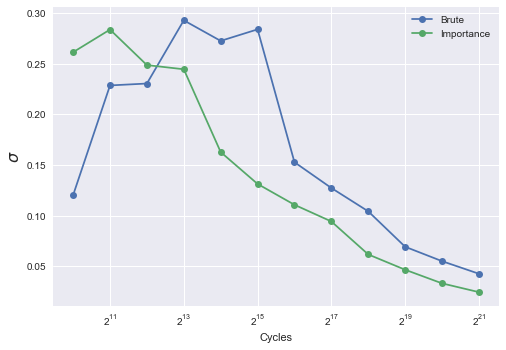

In [7]:
plt.plot(num_samples_list, list(map(np.sqrt, brute_variances)), "o-", label="Brute")
plt.plot(num_samples_list, list(map(np.sqrt, imp_variances)), "o-", label="Importance")
#plt.plot(num_samples_list, brute_variances, label="Brute")
#plt.plot(num_samples_list, imp_variances, label="Importance")
plt.xscale("log", basex=2)
plt.legend(loc="best")
plt.xlabel(r"Cycles")
plt.ylabel(r"$\sigma$", fontsize=16)
plt.show()

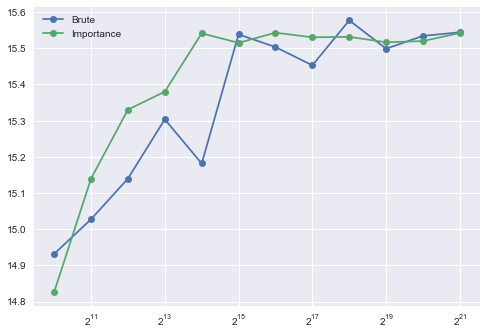

In [8]:
plt.plot(num_samples_list, brute_energies, "o-", label="Brute")
plt.plot(num_samples_list, imp_energies, "o-", label="Importance")
plt.xscale("log", basex=2)
plt.legend(loc="best")
plt.show()

In [9]:
wavefunction = PySimpleGaussian(
            10, num_dimensions, mass, omega, spread=step_length)
    
exact_energies = PyHarmonicOscillator().compute_exact_energy(wavefunction, alphas.ravel())

In [10]:
how_wrong_brute = []
how_wrong_imp = []
for key in df_dict:
    how_wrong_brute.append(np.abs(np.array(exact_energies) - np.array(df_dict[key][0]["energy"])))
    how_wrong_imp.append(np.abs(np.array(exact_energies) - np.array(df_dict[key][1]["energy"])))

In [11]:
how_wrong_brute_mean = [some_array.mean() for some_array in how_wrong_brute]
how_wrong_imp_mean = [some_array.mean() for some_array in how_wrong_imp] 

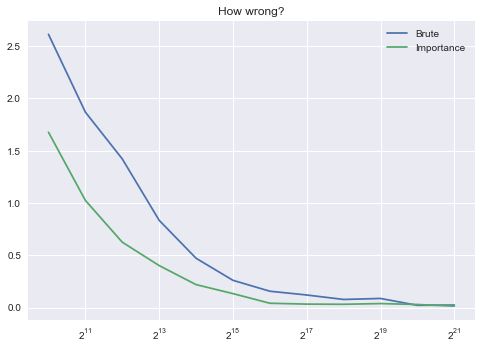

In [12]:
plt.plot(num_samples_list, how_wrong_brute_mean, label="Brute")
plt.plot(num_samples_list, how_wrong_imp_mean, label="Importance")
plt.title("How wrong?")
plt.xscale("log", basex=2)
plt.legend()
plt.show()